In [1]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import closing
from skimage.io import imsave, imread

import cv2

from scipy import ndimage as ndi
from scipy.stats import norm

import os

import plotly.graph_objs as go

import platform

In [2]:
image_filename = '/Users/carolinemccue/Dropbox (MIT)/Project_ReversibleCellAdhesion_Broad/Shear Experiments/MG63/Flat2/10ml.tif'

if os.path.isdir(image_filename):
    img_list = [os.path.join(image_filename,f) for f in os.listdir(image_filename) if f.endswith('.jpg')]
elif os.path.isfile(image_filename):
    img_list = [image_filename]

for image_file in img_list:
        image = cv2.imread(image_file, 0)

In [3]:
x = 0
out_directory = "MG63flat_" + str(x)
while os.path.exists(out_directory):
    x = int(os.path.basename(out_directory).split('_')[1])
    x += 1
    out_directory = "MG63flat_" + str(x)
os.mkdir("MG63flat_" + str(x))

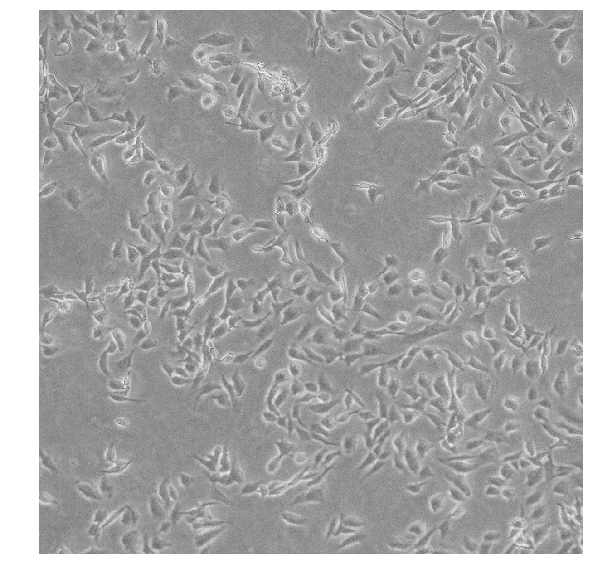

In [4]:
image = image[0:1200,0:1200] #[lines, columns]
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='nearest')

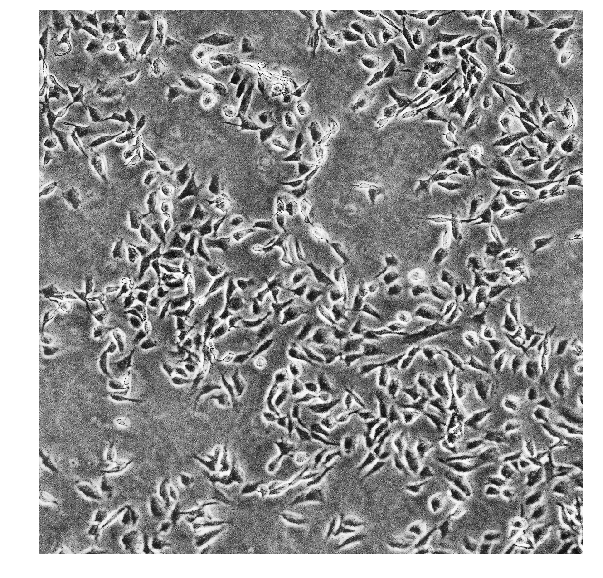

In [6]:
# Adaptive Equalization
clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(10,10))
img_adapteq = clahe.apply(image)
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_adapteq, cmap=plt.cm.gray, interpolation='nearest')

Minimum threshold: 95.0
Min intensity: 1
Max intensity: 254


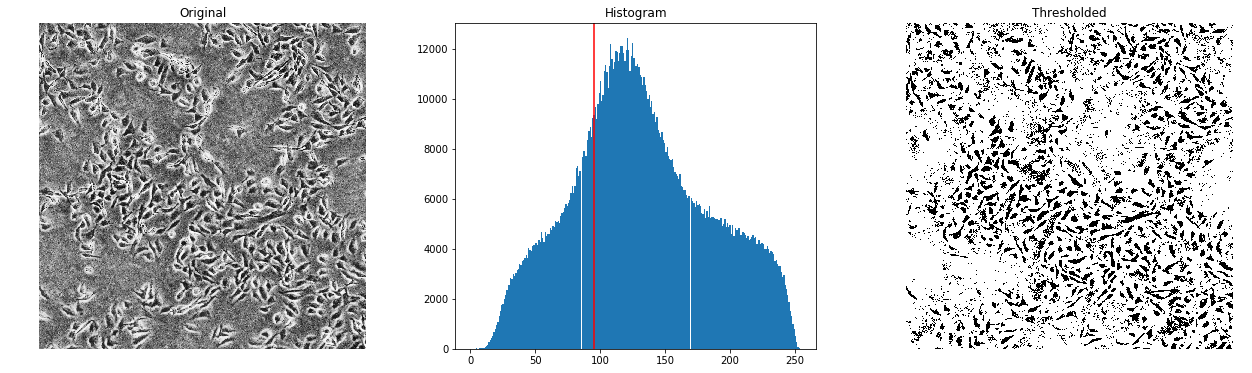

In [7]:
image = img_adapteq

blur = cv2.GaussianBlur(image,(3,3),0)
retVal, binary = cv2.threshold(blur,95,255,cv2.THRESH_BINARY)

fig, axes = plt.subplots(ncols=3, figsize=(22, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(retVal, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

print('Minimum threshold: ' + str(retVal))
print('Min intensity: ' + str(np.min(image)))
print('Max intensity: ' + str(np.max(image)))
plt.show()

/Users/carolinemccue/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/morphology/misc.py:194: UserWarning:

Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?



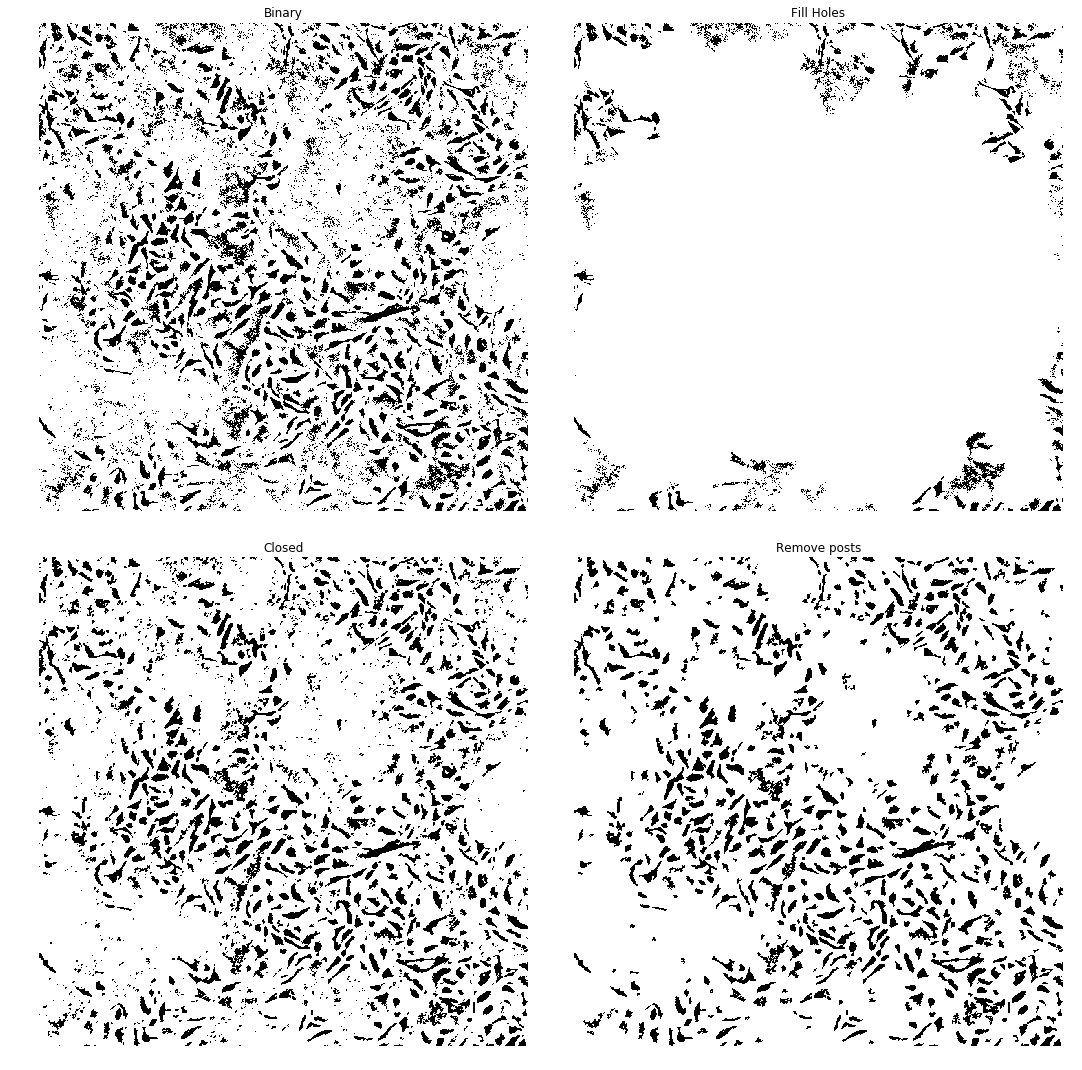

In [8]:
from skimage.morphology  import binary_closing, disk, binary_dilation, remove_small_holes, remove_small_objects
fill_holes = ndi.morphology.binary_fill_holes(binary, structure=np.ones((11,11))).astype('uint8')

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 2)

remove_posts = morphology.remove_small_objects(closed, 50)
remove_posts = morphology.remove_small_holes(remove_posts, 50)
remove_posts = remove_posts.astype(np.uint8)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(binary, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Binary')
ax[1].imshow(fill_holes, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Fill Holes')
ax[2].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Closed')
ax[3].imshow(remove_posts, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Remove posts')


for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

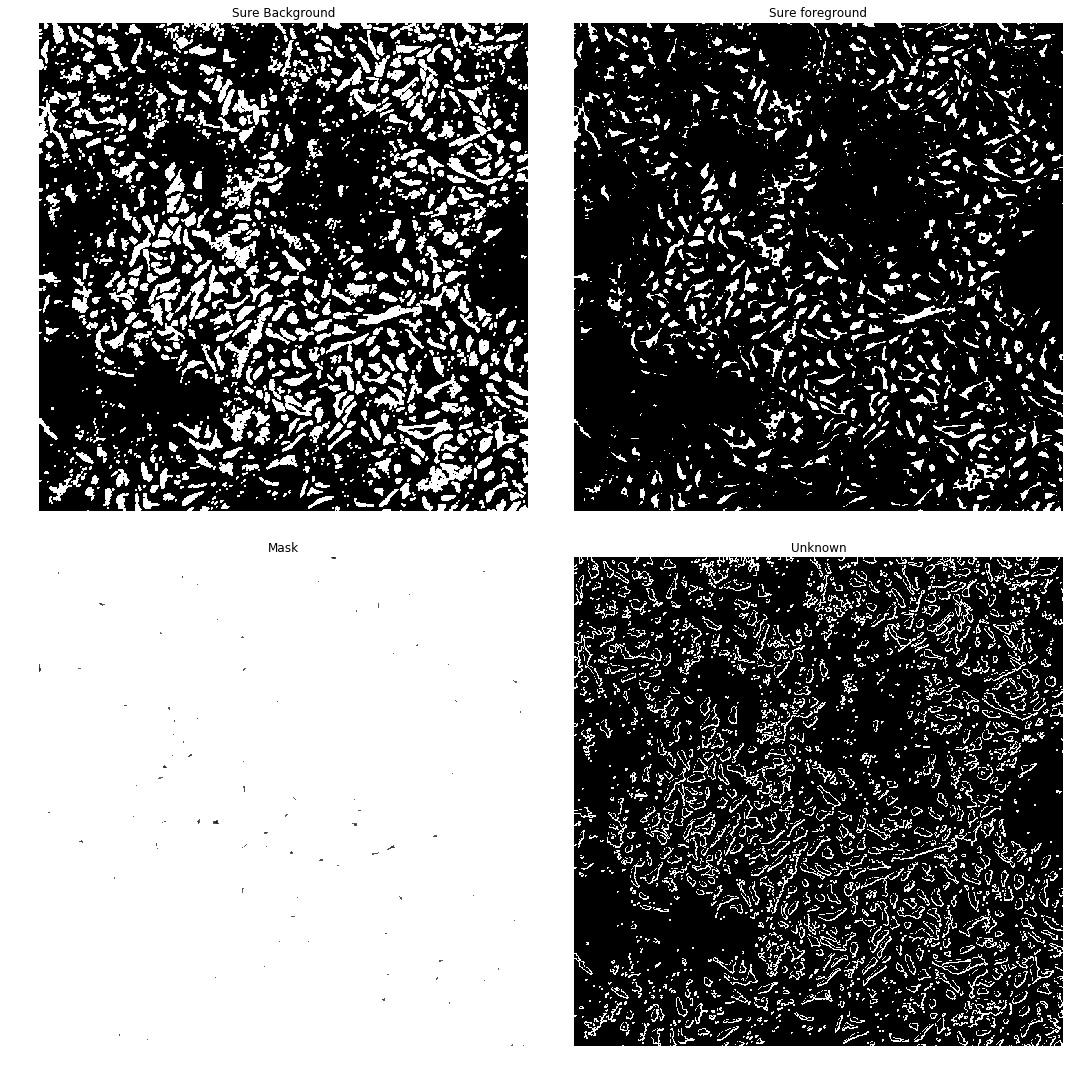

In [9]:
closed = np.invert(closed)
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(remove_posts,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel, iterations = 2)
# sure background area
#sure_bg = cv2.dilate(opening,kernel,iterations=3)
sure_bg = cv2.dilate(closing,kernel,iterations=2)
# Finding sure foreground area
#dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
dist_transform = cv2.distanceTransform(closing,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.15*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

mask = dist_transform.copy()
mask[mask < 8] = 0

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(sure_bg, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Sure Background')
ax[1].imshow(sure_fg, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Sure foreground')
ax[2].imshow(-mask, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Mask')
ax[3].imshow(unknown, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Unknown')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

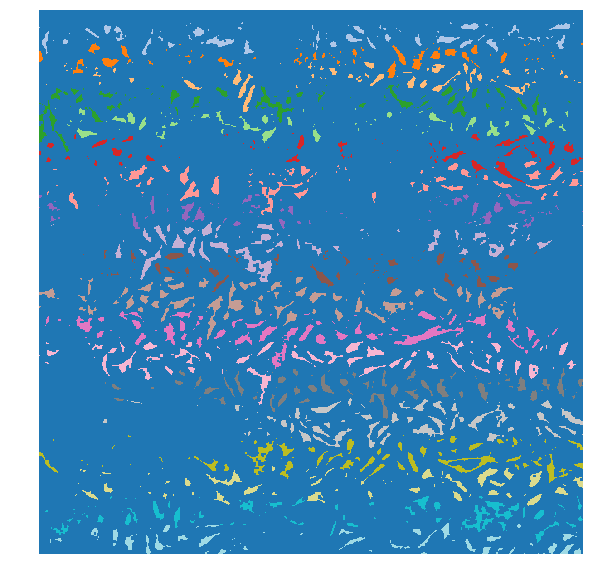

In [10]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers+1
markers[sure_bg] = 1

fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(markers, cmap=plt.cm.tab20)

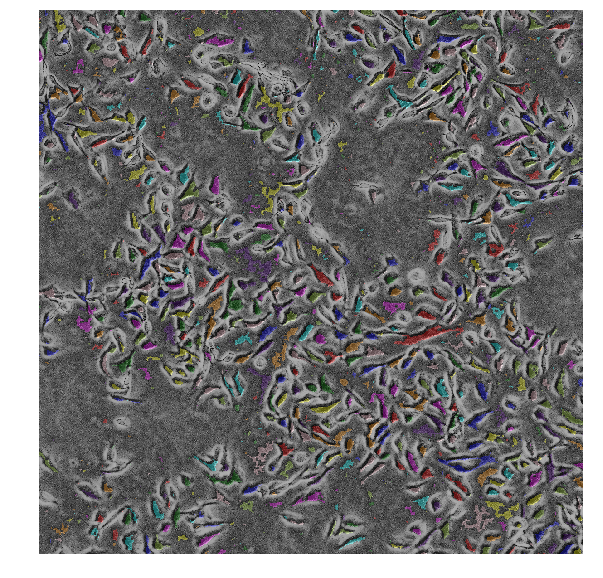

In [11]:
threeChannels = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
segmented = cv2.watershed(threeChannels.astype('uint8'), markers)

# Color the labels sections for display
image_label_overlay = label2rgb(segmented, image, bg_label=1)
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image_label_overlay)

In [ ]:
reg = regionprops(segmented, intensity_image=image)[1:]
cellreg = [region for region in reg if (region.area) > 100 and (region.area) < 25000]

columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image', 'Long Axis', 'Short Axis']
df = pd.DataFrame(columns=columns, dtype=np.float64)
df = df.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image, 'Long Axis':i.major_axis_length, 'Short Axis':i.minor_axis_length} for i in cellreg])
df.head(5)

In [ ]:
df['Area'].median(), df['Area'].mean()

In [ ]:
# Display parameters
org_img = image # Intensity image
border = 35 # Additional pixels to display on each side of the bounding box
ecc_cutoff = 0.05 # circularity cuttoff, removes background circles
ecc_cutoff_upper = 1
area_cutoff_upper = 2*df.Area.mean() # Area cuttoff, removes misidentified shapes (for instance half-droplets)
area_cutoff_lower = 0.1*df.Area.median()
max_col = org_img.shape[1]
max_row = org_img.shape[0]

n_img = len(cellreg)
print("{} cells were detected and segmented".format(n_img))
n_col = 50
n_rows = n_img // n_col + 1

cellreg.sort(key=lambda x: x.area)
cellreg_clean = [region for region in cellreg if (region.area) > area_cutoff_lower and (region.area) < area_cutoff_upper and region.eccentricity > ecc_cutoff and region.eccentricity < ecc_cutoff_upper]

print("{} cells with selected criteria".format(len(cellreg_clean), area_cutoff_lower, area_cutoff_upper))

fig, ax = plt.subplots(n_col, n_rows)
axes = ax.ravel()

for i, region in enumerate(cellreg_clean):
    (min_row, min_col, max_row, max_col) = region.bbox
    drop_image = org_img[np.max([min_row-border,0]):np.min([max_row+border,max_row]),np.max([min_col-border,0]):np.min([max_col+border,max_col])]
    contrast_stretch = exposure.rescale_intensity(drop_image, in_range=(0,255))
    name = os.path.join(out_directory, os.path.basename(image_file).split('.')[0] + '_cell_' + str(i) + '.jpg')
    imsave(name, contrast_stretch, check_contrast=False)
    axes[i].imshow(contrast_stretch, cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=255)
    axes[i].axis('off')
    
for i in range(n_col*n_rows - len(cellreg_clean)):
    axes[-(i+1)].axis('off')
    
fig.set_size_inches(15, 50)


In [ ]:
boxed_regions = image.copy()
for region in cellreg_clean:
    (min_row, min_col, max_row, max_col) = region.bbox
    color = np.uint8(np.random.randint(0, 255, 3)).tolist()
    cv2.rectangle(boxed_regions, (min_col,min_row), (max_col,max_row), color, 3)
    cv2.putText(boxed_regions,'%d'%region.label,(min_col+50, min_row+100), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3, cv2.LINE_AA)
    
fig = plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(boxed_regions, cmap=plt.cm.gray)

In [ ]:
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image', 'Long Axis', 'Short Axis']
df2 = pd.DataFrame(columns=columns, dtype=np.float64)
df2 = df2.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image, 'Long Axis':i.major_axis_length, 'Short Axis':i.minor_axis_length} for i in cellreg_clean])
df2.tail(5)